In [13]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm_notebook as tqdm

from kflib import *

plt.rcParams["figure.figsize"] = (20, 6)

In [ ]:
N = 40
F = 8
x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
x = l96_step(x0, 10)
x_one = l96_step(x0, 73.0)  # spin up
x = l96_step(x_one[-1], 73.0)
x_last = x_one[-1]

if not (os.path.exists("datawithnoise.txt") and os.path.exists("gendata.txt")):
    data = x[::5]
    np.savetxt("gendata.txt", data)
    random_ls = np.random.randn(data.shape[0], x[::5].shape[1])
    datawithnoise = data + random_ls
    np.savetxt("datawithnoise.txt", datawithnoise)
else:
    data = np.loadtxt("gendata.txt")
    datawithnoise = np.loadtxt("datawithnoise.txt")

### 観測を減らす
毎回ランダムに減らす

In [5]:
hani = np.arange(1.0, 1.2, 0.01)
kf_before_ls = []
kf_after_ls = []
for item in tqdm(hani):
    step = 500
    kf_out = kf(x_last, data, datawithnoise, param=item, step=step,del_num=10) 
    kf_before_ls.append(np.array(kf_out[0][101:]).mean())
    kf_after_ls.append(np.array(kf_out[1][101:]).mean())

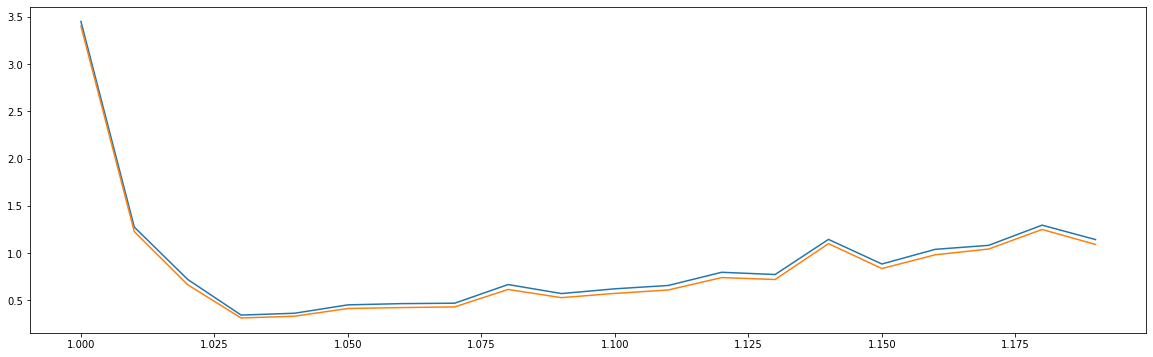

In [6]:
plt.plot(hani, kf_before_ls,label='before_assim')
plt.plot(hani, kf_after_ls,label='after_assim')
plt.savefig('param.png')

In [17]:
def find_best_alpha(del_num):
    # initialize
    step = 200
    hani = np.arange(1.0, 1.14,0.02)
    kf_before_ls,kf_after_ls,  x_ls = [],[],[]
    min_alpha = 10
    min_idx = 0.0
    for item in tqdm(hani):
        try:
            kf_out = kf(x_last, data, datawithnoise, param=item, step=step,del_num=del_num) 
            before_score=np.array(kf_out[0][101:]).mean()
            after_score=np.array(kf_out[1][101:]).mean()
            x_ls.append(item)
            kf_before_ls.append(before_score)
            kf_after_ls.append(after_score)
            if before_score < min_alpha:
                min_alpha = before_score
                min_idx = item
        except ValueError:
            continue
    return x_ls,kf_before_ls, kf_after_ls,min_idx,min_alpha

In [19]:
# RMSEを入れる
kf_kansoku = []
henbun_kansoku = []

In [20]:
for del_num in range(30):
    x_ls,kf_before_ls, kf_after_ls,min_idx,min_alpha = find_best_alpha(del_num)
    kf_kansoku.append(min_alpha)

In [ ]:
plt.plot(kf_kansoku, label='kf')